In [112]:
#read all words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)






In [113]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

class Linear: 

    def __init__(self, fan_in: int, fan_out: int, bias:bool=True):
        self.weight = torch.randn((fan_in, fan_out)) #/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim: int, eps:float=1e-5, momentum:float=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


In [117]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
block_size = 3 # context length: how many characters do we take to predict the next one? 
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

def build_dataset(words):
    X, Y = [], []

    for w in words: 
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:]) 

g = torch.Generator().manual_seed(2147483647)# for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(n_hidden)
]

# some initialization
with torch.no_grad():
    # last layer: make less confident
    # layers[-1].gama *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True  

            

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])
47497


In [ ]:
Xtr.shape

torch.Size([182778, 3])

In [ ]:
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    X = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        X = layer(X)
    loss = F.cross_entropy(X, Yb) # loss function
   
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()
   
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
   
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])


    
    

      0/  20000: 3.3035
  10000/  20000: 2.1536


layer 1 (      Tanh): mean +0.03, std 0.83, saturated: 33.53%
layer 4 (      Tanh): mean +0.01, std 0.65, saturated: 6.88%
layer 7 (      Tanh): mean +0.02, std 0.67, saturated: 6.34%
layer 10 (      Tanh): mean +0.00, std 0.69, saturated: 5.78%
layer 13 (      Tanh): mean +0.01, std 0.64, saturated: 2.81%


Text(0.5, 1.0, 'activation distribution')

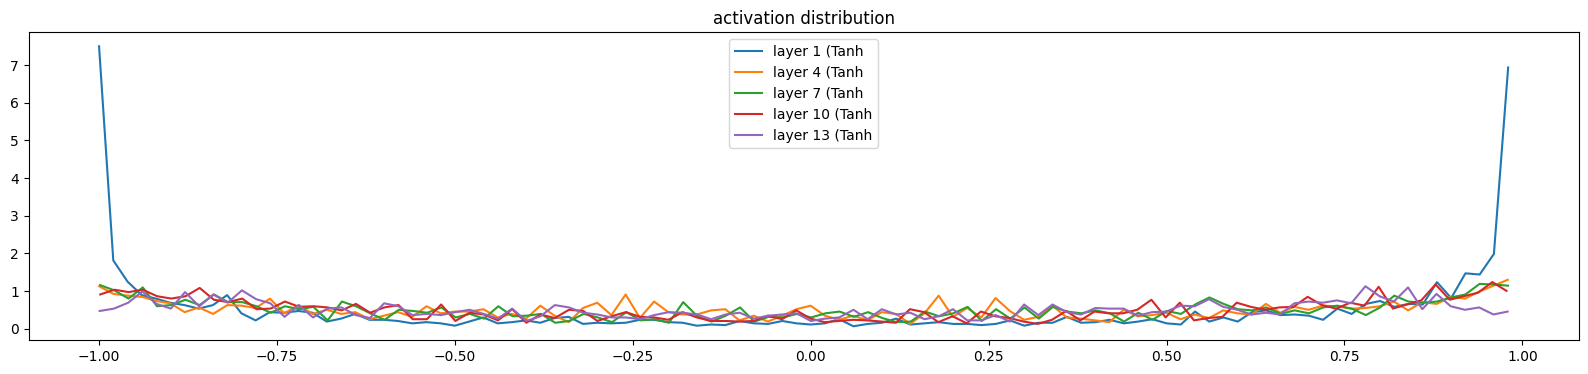

In [ ]:
#Visualize Histograms of the Activations
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 1 (      Tanh): mean -0.000000, std 6.000034e-03
layer 4 (      Tanh): mean +0.000000, std 4.178761e-03
layer 7 (      Tanh): mean +0.000000, std 3.634164e-03
layer 10 (      Tanh): mean +0.000000, std 3.607549e-03
layer 13 (      Tanh): mean -0.000017, std 4.488054e-03


Text(0.5, 1.0, 'gradient distribution')

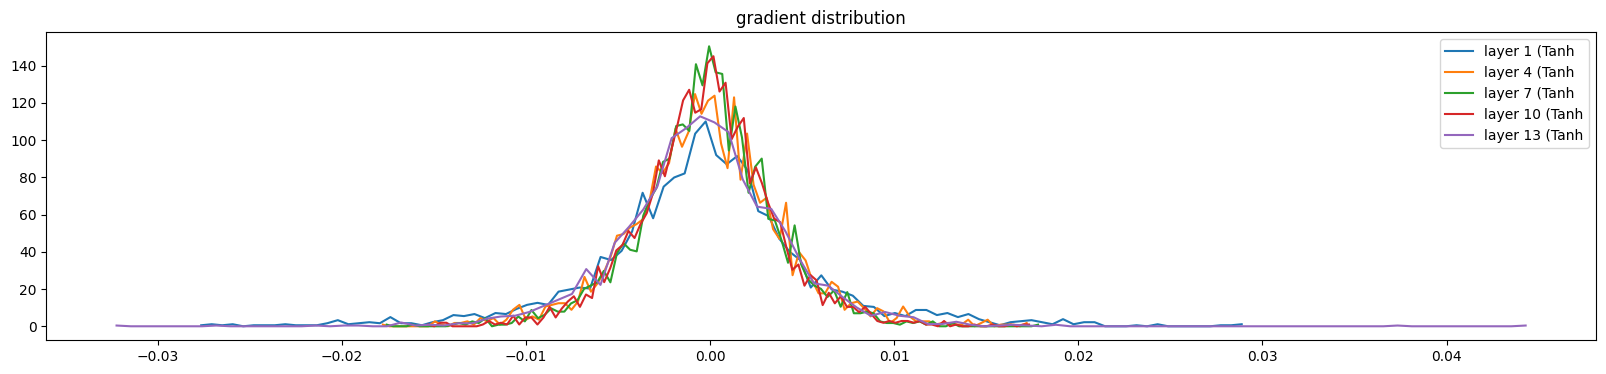

In [ ]:
#visualize gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000578 | std 1.645299e-02 | grad: weights 1.064866e+00, grad 1.645299e-02 | grad: data ratio 1.545076e-02
weight  (30, 100) | mean +0.000053 | std 1.200236e-02 | grad: weights 3.485421e-01, grad 1.200236e-02 | grad: data ratio 3.443589e-02
weight (100, 100) | mean +0.000143 | std 8.663242e-03 | grad: weights 1.945030e-01, grad 8.663242e-03 | grad: data ratio 4.454041e-02
weight (100, 100) | mean -0.000014 | std 6.647643e-03 | grad: weights 1.863468e-01, grad 6.647643e-03 | grad: data ratio 3.567351e-02
weight (100, 100) | mean +0.000010 | std 6.141084e-03 | grad: weights 1.846383e-01, grad 6.141084e-03 | grad: data ratio 3.326008e-02
weight (100, 100) | mean -0.000028 | std 6.282581e-03 | grad: weights 1.854834e-01, grad 6.282581e-03 | grad: data ratio 3.387139e-02
weight  (100, 27) | mean +0.000000 | std 1.983051e-02 | grad: weights 1.474678e-01, grad 1.983051e-02 | grad: data ratio 1.344735e-01


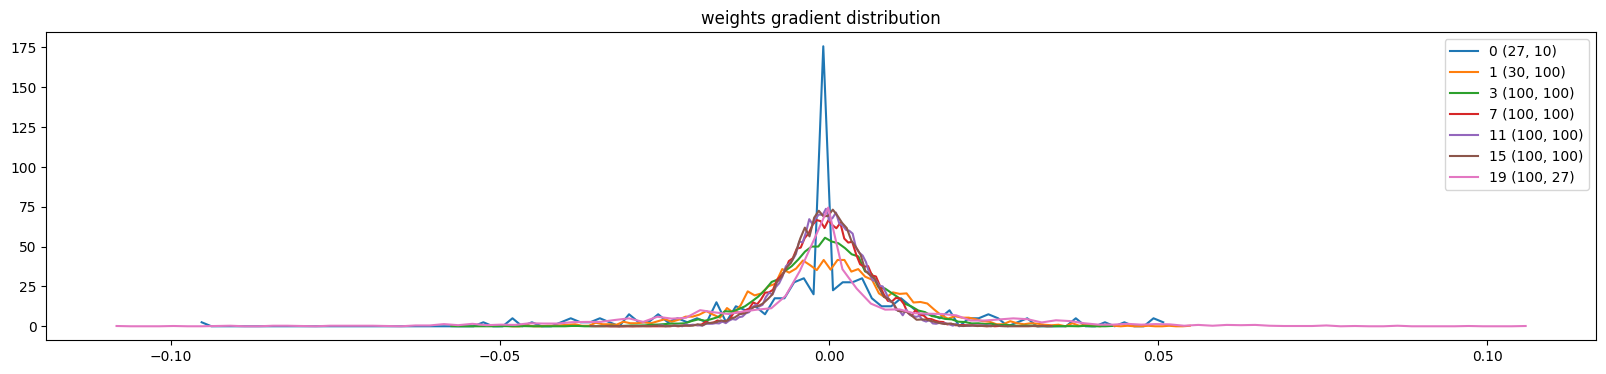

In [ ]:
# visualize weights 
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad: weights %e, grad %e | grad: data ratio %e' % (tuple(p.shape), t.mean(), t.std(), p.data.std(), t.std(), t.std() / p.data.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');



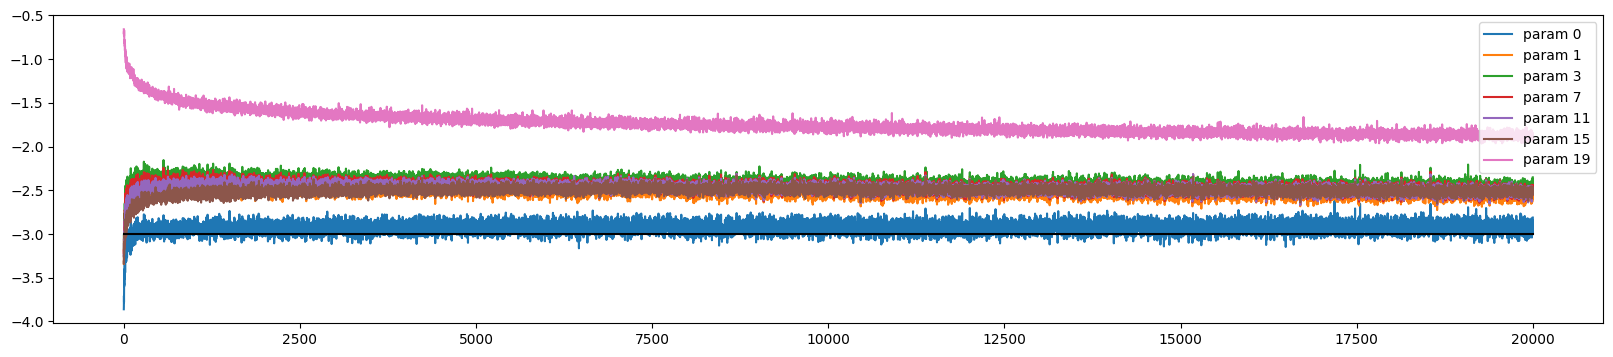

In [ ]:
# visualize weight updates 
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, otherwise things are exploding
plt.legend(legends);